In [1]:
#import required modules and packages 
from collections import Counter
from wordcloud import WordCloud
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv ("metadata.csv", low_memory=False)  #load dataset

df.head()  #see the first 5 rows 

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [3]:
print ("Shape of dataset:", df.shape)  #rows and columns 

print (df.info())  #columns and datatypes 

Shape of dataset: (1056660, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056660 entries, 0 to 1056659
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   cord_uid          1056660 non-null  object 
 1   sha               373766 non-null   object 
 2   source_x          1056660 non-null  object 
 3   title             1056157 non-null  object 
 4   doi               656780 non-null   object 
 5   pmcid             389571 non-null   object 
 6   pubmed_id         498932 non-null   object 
 7   license           1056660 non-null  object 
 8   abstract          821116 non-null   object 
 9   publish_time      1054846 non-null  object 
 10  authors           1032791 non-null  object 
 11  journal           969338 non-null   object 
 12  mag_id            0 non-null        float64
 13  who_covidence_id  482935 non-null   object 
 14  arxiv_id          14249 non-null    object 
 15  pdf_json_files   

In [4]:
# sorted missing values 
missingValues = df.isnull().sum().sort_values(ascending=False) #count missing values per column 

print (missingValues)

mag_id              1056660
arxiv_id            1042411
pmc_json_files       740918
pdf_json_files       682894
sha                  682894
pmcid                667089
who_covidence_id     573725
pubmed_id            557728
doi                  399880
url                  369726
abstract             235544
journal               87322
s2_id                 80192
authors               23869
publish_time           1814
title                   503
license                   0
source_x                  0
cord_uid                  0
dtype: int64


In [5]:
# dropping rows with high missing values 
df_clean = df.dropna(subset=['title', 'publish_time']).copy() #rows with missing title and publish time 

df_clean['abstract'] = df_clean['abstract'].fillna(" ")   #filling empty cells with empty string 

df_clean ['publish_time'] = pd.to_datetime(df_clean ['publish_time'], errors = 'coerce')  #convert publish time to datetime

df_clean['year'] = df_clean['publish_time'].dt.year  #extracting publication year

df_clean['abstract_word_count'] = df_clean['abstract'].apply(lambda x: len(x.split())) #create abstract word count column


print("Shape after cleaning:", df_clean.shape)
df_clean.head()


Shape after cleaning: (1054343, 21)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,year,abstract_word_count
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,...,BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,2001.0,262
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000.0,142
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2000.0,219
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2001.0,68
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,...,Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN,2001.0,110


In [6]:
print (df_clean.info())  #columns and datatypes 

<class 'pandas.core.frame.DataFrame'>
Index: 1054343 entries, 0 to 1056659
Data columns (total 21 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   cord_uid             1054343 non-null  object        
 1   sha                  373762 non-null   object        
 2   source_x             1054343 non-null  object        
 3   title                1054343 non-null  object        
 4   doi                  655180 non-null   object        
 5   pmcid                389562 non-null   object        
 6   pubmed_id            498432 non-null   object        
 7   license              1054343 non-null  object        
 8   abstract             1054343 non-null  object        
 9   publish_time         518429 non-null   datetime64[ns]
 10  authors              1030559 non-null  object        
 11  journal              968693 non-null   object        
 12  mag_id               0 non-null        float64       
 13  wh

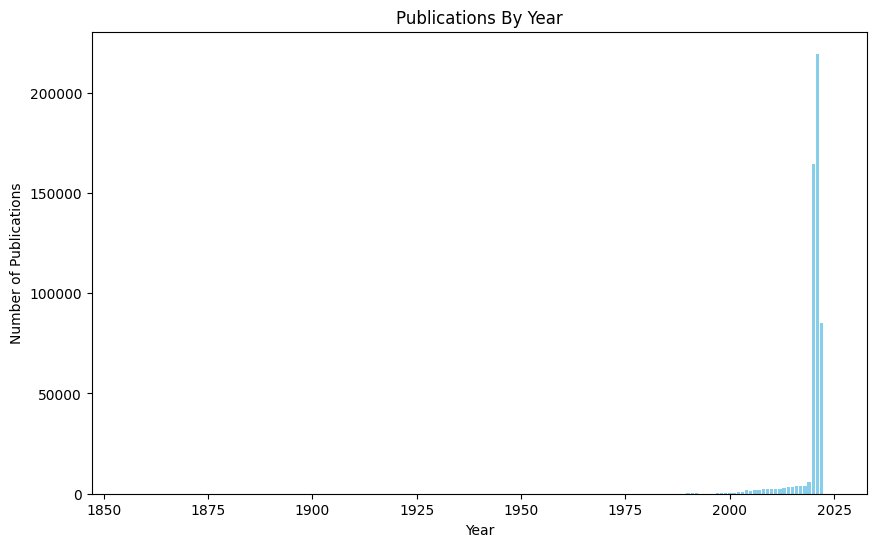

In [7]:
#data analysis and visualization 

#count papers by publication year 
year_counts = df_clean['year'].value_counts().sort_index()

#ploting this over time 
plt.figure(figsize = (10, 6))
plt.bar (year_counts.index, year_counts.values, color = "skyblue")
plt.title ("Publications By Year")
plt.xlabel ("Year")
plt.ylabel ("Number of Publications")
plt.show()

#this will show how the covid-19 related publications change over time 

journal
PLoS One                           9953
bioRxiv                            8961
Int J Environ Res Public Health    8201
BMJ                                6928
Sci Rep                            5935
Cureus                             4212
Reactions Weekly                   3891
Front Psychol                      3541
BMJ Open                           3515
Front Immunol                      3442
Name: count, dtype: int64


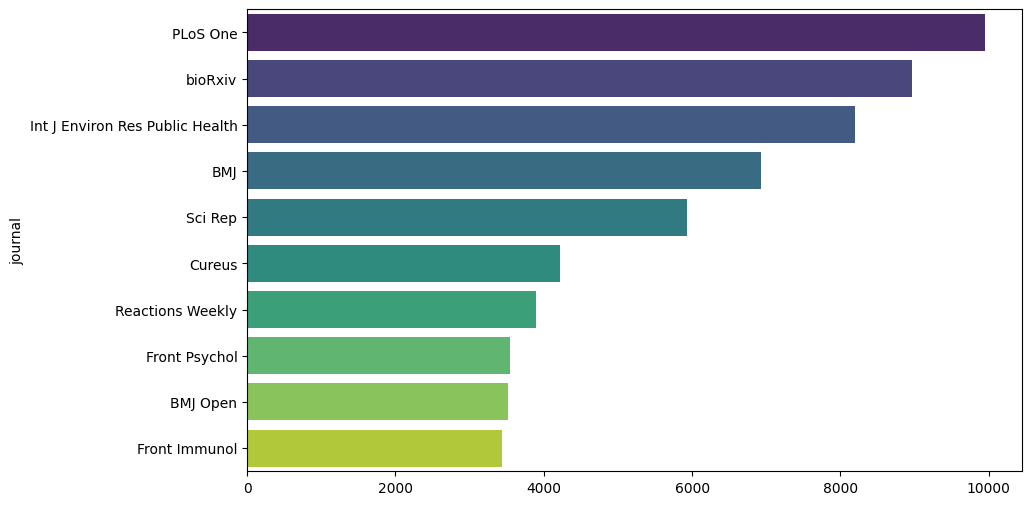

In [8]:
# identifying the top 10 journals by count

top_journals = df_clean['journal'].value_counts().head(10)

print (top_journals)

# a bar plot of the above 
plt.figure(figsize=(10, 6))
sns.barplot(x=top_journals.values, y=top_journals.index, hue=top_journals.index, dodge=False, palette="viridis", legend=False)
plt.title = ("Top 10 Journals Publishing COVID-19 Research")
plt.xlabel = ("Numbers of Papers")
plt.ylabel = ("Journals")
plt.show()

# this helps use to see where most reseach was published 

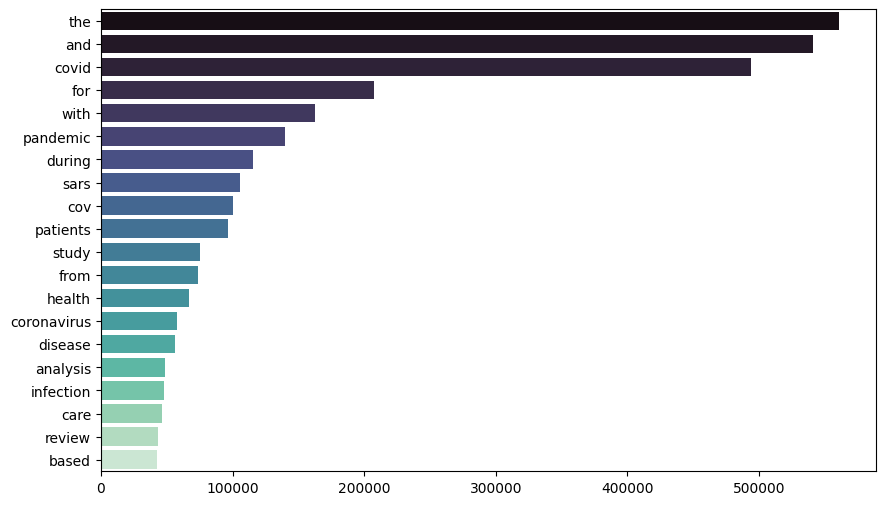

In [9]:
# most frequent words in titles 
# combine titles into one big string 
titles = " ".join(df_clean["title"].dropna().tolist()).lower()
words = re.findall(r"\b[a-z]{3,}\b", titles)
word_freq = Counter (words)
top_words = word_freq.most_common(20)
words_list, counts = zip(*top_words)

#plotting 
plt.figure (figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words_list), hue=list(words_list), dodge=False, palette="mako", legend=False)
plt.title = ("Top 20 Most Frequent Words in Paper Titles")
plt.xlabel = ("Frequency")
plt.ylabel = ("Word")
plt.show()

TypeError: 'str' object is not callable

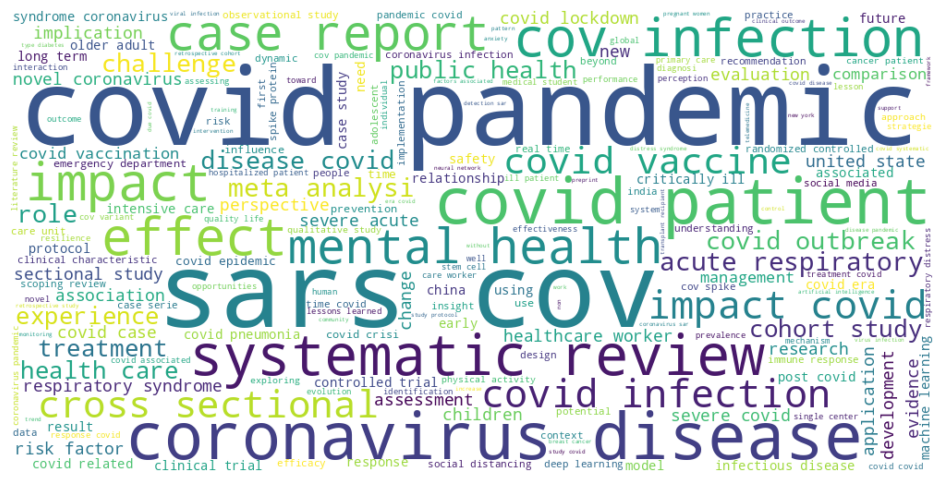

In [10]:
#joining all words and creating a word cloud 
all_words = " ".join(words)
wordcloud = WordCloud (width = 1000, height = 500,
                      background_color  = "white",
                      colormap = "viridis").generate(all_words)

# ploting
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Paper Titles", fontsize=16)
plt.show()